## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('flights_samp.csv')

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [8]:
df.dep_delay

0       -6.0
1       -1.0
2        6.0
3       -3.0
4       16.0
        ... 
4995    -1.0
4996   -10.0
4997    -6.0
4998    -6.0
4999    12.0
Name: dep_delay, Length: 5000, dtype: float64

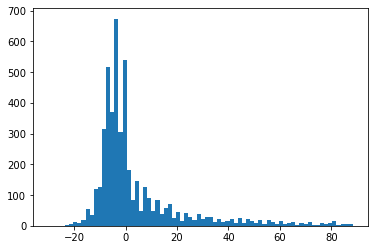

In [18]:
plt.hist(df.dep_delay, bins=np.arange(-30,90, 1.6));

In [3]:
col_index_drop = df.isnull().sum() / df.shape[0] > 0.5
col_to_drop = np.append(df.columns[col_index_drop], ['index', 'dup', 'tail_num', 'crs_elapsed_time'])

In [4]:
col_to_drop

array(['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'first_dep_time',
       'total_add_gtime', 'longest_add_gtime', 'no_name', 'index', 'dup',
       'tail_num', 'crs_elapsed_time'], dtype=object)

In [5]:
df = df.drop(columns=col_to_drop, axis=1)

In [6]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'diverted', 'actual_elapsed_time',
       'air_time', 'flights', 'distance'],
      dtype='object')

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [ ]:
# We've chosen to take a more narrow sample to closely represent what model will be testing (first week of January, and 5 days on either side - not including Dec 25)
# However, the day of week/ holiday phenomenon would be interesting to look at

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [4]:
def split_time_of_day_departure(df):
    """ takes estimated time of departure and splits in to hours 24 hour clock (local time) """
    df['dep_hour'] = df['crs_dep_time']
    df['dep_hour'] = np.floor(df['dep_hour']/100).astype("int")
    return df
df = split_time_of_day_departure(df)

def split_time_of_day_arrival(df):
    """ takes estimated time of arrival and splits in to hours 24 hour clock (local time) """
    df['arr_hour'] = df['crs_arr_time']
    df['arr_hour'] = np.floor(df['arr_hour']/100).astype("int")
    return df
df = split_time_of_day_arrival(df)



#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

In [ ]:
# SPLIT DATA INTO STATES AND CITIES
def split_dest_city_state(df):
    """ separates destination city and states into own columns"""
    df['dest_state'] = df['dest_city_name']
    df['dest_city'] = df['dest_city_name']
    
    f_state= lambda x: x.split(sep=', ')[1]
    f_city= lambda x: x.split(sep=', ')[0]

    df['dest_state'] = df['dest_state'].apply(f_state)
    df['dest_city'] = df['dest_city'].apply(f_city)
    return df

def split_origin_city_state(df):
    """ separates origin city and states into own columns"""
    df['origin_state'] = df['origin_city_name']
    df['origin_city'] = df['origin_city_name']
    
    f_state= lambda x: x.split(sep=', ')[1]
    f_city= lambda x: x.split(sep=', ')[0]

    df['origin_state'] = df['origin_state'].apply(f_state)
    df['origin_city'] = df['origin_city'].apply(f_city)
    return df

df = split_dest_city_state(df)
df = split_origin_city_state(df)

# CALCULATE FLIGHT COUNTS PER STATES
state_count_orig = df[['origin_state', 'index']].groupby('origin_state', as_index=False).count().sort_values(by='index')
state_count_dest = df[['dest_state', 'index']].groupby('dest_state', as_index=False).count().sort_values(by='index')
state_count= state_count_orig.merge(state_count_dest, left_on='origin_state', right_on='dest_state')

state_count['total_flights'] = state_count['index_x']+state_count['index_y']
state_count.rename(columns = {'origin_state': 'state'}, inplace=True)
state_count.drop(['index_x', 'dest_state', 'index_y'], axis=1, inplace=True)

state_count= state_count.sort_values(by='total_flights', ascending=False)

# CALULATE HOW MANY STATES ACCOUNT FOR 50% OF ALL TRAFFIC IN USA
state_list = list(state_count.state)
flight_count_list = list(state_count.total_flights)

total_flights = state_count.total_flights.sum()
total_flights

top_state=[]
flight_counts=0
i=0
while flight_counts < total_flights/2:
    top_state.append(state_list[i])

    flight_counts += flight_count_list[i]
    i+=1


print("Number of top trafficed states accounting for 50% of traffic: ", len(top_state))
top_state


In [ ]:
# PLOT NUMBER OF FLIGHTS PER STATE
# import matplotlib
import matplotlib.pyplot as plt

x1 = state_count_orig['origin_state']
x2 = state_count_dest['dest_state']

y1 = state_count_orig['index']
y2 = state_count_dest['index']

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize = (20,15))

ax1.barh(x1,y1)
ax1.set_ylabel('Number of Flights Outbound per State', fontsize=12)
ax1.set_xlabel('State', fontsize=12)
ax1.set_title('Number of OUTBOUND Flights STATE', fontsize=20, y=1.05)

ax2.barh(x2,y2)
ax2.set_ylabel('Number of  Flights Inbound per State', fontsize=12)
ax2.set_xlabel('State', fontsize=12)
ax2.set_title('Number of INBOUND Flights STATE', fontsize=20, y=1.05)
# add legend

plt.show()

# Can see 3 teirs of aiport size (CA-CO, PA-MD, and VA-and below)

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [ ]:
# CREATE HOUR OF DAY AND HAUL TYPE COLUMNS

def split_time_of_day_departure(df):
    """ takes estimated time of departure and splits in to hours 24 hour clock (local time) """
    df['dep_hour'] = df['crs_dep_time']
    df['dep_hour'] = np.floor(df['dep_hour']/100).astype("int")
    return df
  
def create_haul_type(df):
    """ adds short:0, mid:1, long:2 range haul types from crs_elapsed_time (scheduled) """

    df["haul_type"] = df['crs_elapsed_time']
    df["haul_type"].mask(df["haul_type"].values < 180, 0, inplace=True)
    df["haul_type"].mask((df["haul_type"] >= 180) & (df["haul_type"] < 360), 1, inplace=True)
    df["haul_type"].mask((df["haul_type"] >= 360), 2, inplace=True) 
    df["haul_type"]= df["haul_type"].astype('int')
    return df  

df = split_time_of_day_departure(df)
df = create_haul_type(df)
df.haul_type.unique()




In [ ]:
# want departure time for each category - SPLIT APART

df_haul_type = df[['haul_type', 'dep_hour', 'index']]
df_haul_type = df_haul_type.groupby(['dep_hour','haul_type'], as_index=False).count()

short_haul = df_haul_type[df_haul_type.haul_type == 0]
med_haul = df_haul_type[df_haul_type.haul_type == 1]
long_haul = df_haul_type[df_haul_type.haul_type == 2]

In [ ]:
# PLOT EACH HAUL TYPE TO VISULIZE
import matplotlib.pyplot as plt
# Long Haul Plot

x = long_haul.dep_hour
y = long_haul['index']

fig, ax = plt.subplots( figsize = (7,7))

ax.bar(x,y)
ax.set_ylabel('Number of flights departing', fontsize=12)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title('Long Haul Departure time', fontsize=20, y=1.05)

plt.show()

In [ ]:
# Mid Haul Plot

x = med_haul.dep_hour
y = med_haul['index']

fig, ax = plt.subplots( figsize = (7,7))

ax.bar(x,y)
ax.set_ylabel('Number of flights departing', fontsize=12)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title('Med Haul Departure time', fontsize=20, y=1.05)

plt.show()

In [ ]:
# short Haul Plot

x = short_haul.dep_hour
y = short_haul['index']

fig, ax = plt.subplots( figsize = (7,7))

ax.bar(x,y)
ax.set_ylabel('Number of flights departing', fontsize=12)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title('Short Haul Departure time', fontsize=20, y=1.05)

plt.show()

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [ ]:
# CALCULATE FLIGHT COUNTS PER AIRPORTS
airport_count_orig = df[['origin_airport_id', 'index']].groupby('origin_airport_id', as_index=False).count().sort_values(by='index', ascending = False)
airport_count_dest = df[['dest_airport_id', 'index']].groupby('dest_airport_id', as_index=False).count().sort_values(by='index')
airport_count= airport_count_orig.merge(airport_count_dest, left_on='origin_airport_id', right_on='dest_airport_id')

airport_count['total_flights'] = airport_count['index_x']+airport_count['index_y']
airport_count.rename(columns = {'origin_airport_id': 'airport_id'}, inplace=True)
airport_count.drop(['index_x', 'dest_airport_id', 'index_y'], axis=1, inplace=True)
airport_count.head()

In [ ]:
# CALULATE TOP 10 AIRPORTS
top_airport_counts = airport_count.sort_values(by='total_flights', ascending=False).head(50)

top_airport_counts.airport_id= top_airport_counts.airport_id.astype('string')
top_airport_counts.head()

# TRY TO GET HUMAN READABLE AIRPORT CODE
# airport_code = []
# for i in range(len(top_airport_counts)):
#     airport_code.append(df[df['origin_airport_id'] == top_airport_counts.iloc[i].airport_id].origin)
# top_airport_counts.airport_code 

In [ ]:
# PLOT AIRPORT FLIGHT VOLUME

import matplotlib.pyplot as plt

x = top_airport_counts.airport_id

y = top_airport_counts.total_flights

fig, ax = plt.subplots( figsize = (10,10))

ax.bar(x,y)
ax.set_ylabel('Total Number of Flights per Airport', fontsize=12)
ax.set_xlabel('Airport', fontsize=12)
ax.set_title('Number of Flights', fontsize=20, y=1.05)

plt.show()

# Can split into 3 teirs as well

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?